# Deep Learning Assignment - 01 , Set - 5 

## Problem - 01, Group - 029
## Vision Dataset - Animal Image Classification using ANN


## Library Imports

In [1]:
import os
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

## Validate GPU Availability

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

1 Physical GPUs, 1 Logical GPUs


## Load the dataset and validate the data load

In [3]:
# Check the path - the folder structure

folder = "/home/suvo/Documents/LargeDatasets/CNNDatasets/Cats-Dogs-Pandas/animals"
listdir(folder)

['cats', 'dogs', 'panda']

#### Display six images from each of the classes

In [4]:
# Function to display six images from each of the directories

def plotImages(species):
    # define the location of the image
    location = folder + "/" + species + "/"
    # plot the first few images
    plt.figure(figsize=(12, 8))
    for index in range(6):
        # define subplot
        plt.subplot(330 + 1 + index)
        # define filename
        filename = location + species + '_0000' + str(index + 1) + '.jpg'
        # load image pixels
        image = imread(filename)
        # plot the raw pixel data
        plt.imshow(image)
    # Show the figure
    plt.show()

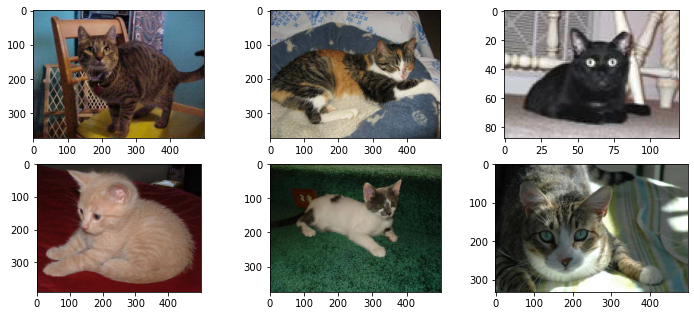

In [5]:
plotImages('cats')

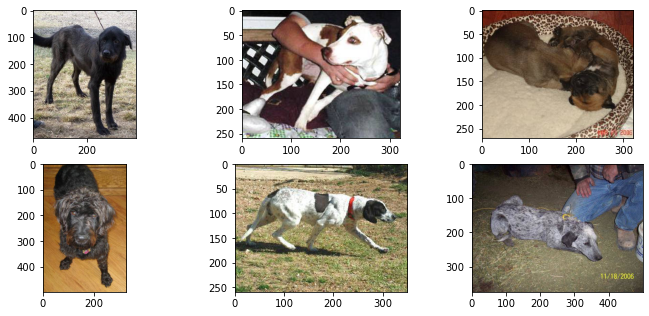

In [6]:
plotImages('dogs')

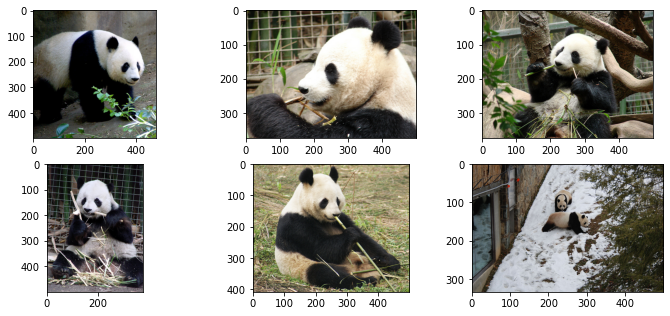

In [7]:
plotImages('panda')

In [8]:
# we will find out the number of images and classes in the given path

imageList=[]
classList=[]

for file1 in listdir(folder):
    file2 = folder + "/" + file1
    for file3 in listdir(file2):
        file4 = file2 + "/" + file3
        image = tf.keras.preprocessing.image.load_img(file4, target_size=(128, 128))
        image = tf.keras.preprocessing.image.img_to_array(image)
        imageList.append(image)
        classList.append(file1)

# Check whether all the images has been parsed
print(f"Length of the image list - {len(imageList)}")
print(f"Length of the class list - {len(classList)}")

Length of the image list - 3000
Length of the class list - 3000


## Data Preprocessing and Preparation for Neural Network Modelling

In [9]:
# We will convert this list into numpy array
imageArray = np.asarray(imageList)
classArray = np.asarray(classList)

print(f"Shape of the image numpy array - {imageArray.shape}")
print(f"Shape of the class numpy array - {classArray.shape}")

Shape of the image numpy array - (3000, 128, 128, 3)
Shape of the class numpy array - (3000,)


In [10]:
# The type of the imageArray and classArray should now be an ndarray from numpy
type(imageArray)

numpy.ndarray

#### Normalizing our image array
we will want all our pixel values to be between 0 and 1 (normalized), in order for the neural net to train faster

In [11]:
imageArray = imageArray/255.0

#### Reshaping the image

We are flattening every image meaning we're going to transform each of the dimensions of the image for all the images of the array by flattening all the pixels into a single one vector and we will do that through reshape


In [12]:
imageArray = imageArray.reshape(-1, imageArray.shape[1]*imageArray.shape[2]*imageArray.shape[3])
imageArray.shape

(3000, 49152)

#### Label Encoding the class array

In [13]:
# Label encoding for "cats", "dogs", "pandas"
encoder = LabelEncoder()
classArray = encoder.fit_transform(classArray)

# Convert to categorical
classArray = tf.keras.utils.to_categorical(classArray)
classArray.shape

(3000, 3)

## Train-Test Split

In [14]:
# Perform the split
features_train, features_test, target_train, target_test = train_test_split(imageArray, classArray, test_size=0.3, shuffle=True, 
                                                                            random_state=44)

# We will further split the training set into validatoion to evaluate the Neural Network training
features_train, features_val, target_train, target_val = train_test_split(features_train, target_train, test_size=0.3, 
                                                                            random_state=44)

print("Training Features shape: ", features_train.shape)
print("Training Target shape: ", target_train.shape)

print("Validation Features shape: ", features_val.shape)
print("Validation Target shape: ", target_val.shape)

print("Test Features shape: ", features_test.shape)
print("Training Target shape: ", target_test.shape)

Training Features shape:  (1470, 49152)
Training Target shape:  (1470, 3)
Validation Features shape:  (630, 49152)
Validation Target shape:  (630, 3)
Test Features shape:  (900, 49152)
Training Target shape:  (900, 3)


## Building the ANN

### Global Model Constants

**The number of neurons in the hidden layer is taken as 128 (which is actually a power of 2). Since Matrix operations is at the heart of deep learning computations, Modern CPUs support SIMD operations , which process numbers in batch sizes, which are powers of 2.
Also number of physical processors also exist mostly as a power of 2. Therefore, if the number of computations is not a power of 2, the computations can't be mapped 1:1 and have to be moved around, requiring additional memory management. Hence a power of 2 is a good place to begin**

In [15]:
# Define some global Model Constants

INPUT_SHAPE = (imageArray.shape[1], )
OUTPUT_UNITS = 3
HIDDEN_UNITS= 128
ACTIVATION_HIDDEN = tf.keras.activations.relu
ACTIVATION_OUTPUT = tf.keras.activations.softmax
LEARNING_RATE = 1e-3
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)
LOSS_FUNCTION = tf.keras.losses.categorical_crossentropy
DROPOUT_RATE = 0.2

EPOCHS = 50

In [16]:
# Define the Metrics - These are the metrics we will evaluate during training

METRICS = [tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')]

In [17]:
# Defining a function which will build and compile the model

'''
This will build and compile a basic model with one hidden layer and 16 neurons
'''
def make_basicModel(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN, 
                                input_shape=INPUT_SHAPE))
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN))
    model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [18]:
# Defining a function which will build and compile the model

'''
This will build and compile a regularized model with dropouts
'''
def make_regularizedModel(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN, 
                                input_shape=INPUT_SHAPE))
    model.add(tf.keras.layers.Dropout(rate=DROPOUT_RATE, seed=44))
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN))
    model.add(tf.keras.layers.Dropout(rate=DROPOUT_RATE, seed=44))
    model.add(tf.keras.layers.Dense(units=HIDDEN_UNITS, activation=ACTIVATION_HIDDEN))
    model.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=ACTIVATION_OUTPUT))
    model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=metrics)
    return model

In [19]:
# Defining a function to plot training loss vs validation loss

'''
This function will take a epoch model from training a neural network
Will plot training loss vs validation loss
'''

def plotTrainLossVsValLoss(epochs_history):
    plt.figure(figsize=(12, 8))
    loss_train = epochs_history.history['loss']
    loss_val = epochs_history.history['val_loss']

    plt.figure(figsize=(12, 8))

    loss_train = epochs_history.history['loss']
    loss_val = epochs_history.history['val_loss']

    epochs = range(1, (EPOCHS + 1))
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    plt.title('Training Loss vs Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [20]:
# Defining a function to plot training accuracy vs validation accuracy

'''
This function will take a epoch model from training a neural network
Will plot training accuracy vs validation accuracy
'''

def plotTrainAccuracyVsValAccuracy(epochs_history):
    plt.figure(figsize=(12, 8))

    loss_train = epochs_history.history['accuracy']
    loss_val = epochs_history.history['val_accuracy']

    epochs = range(1, (EPOCHS + 1))
    plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
    plt.plot(epochs, loss_val, 'b', label='Validation Accuracy')
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

#### Compile both the Models and Check the summary

In [21]:
# Lets build the basicModel and see the mmodel summary

basicModel = make_basicModel()
basicModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 6,308,483
Trainable params: 6,308,483
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Lets build the regularizedModel and see the mmodel summary

regularizedModel = make_regularizedModel()
regularizedModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 6,324,995
Trainable params: 6,324,995
Non-trainable params: 0
____________________________________________

## Training the Basic Model

In [23]:
# we will now train the basicModel on training and validation data
# Now use the function to plot the confusion matrix

start = datetime.now()
epochs_history_basic = basicModel.fit(features_train, target_train, epochs=EPOCHS,
                          validation_data=(features_val, target_val),
                          verbose=1)
end = datetime.now()
print(f"The training of basicModel completed in time - {end - start}")

Epoch 1/50
46/46 [==============================] - 2s 25ms/step - loss: 4.5968 - tp: 300.9574 - fp: 389.8723 - tn: 1144.5957 - fn: 466.2766 - accuracy: 0.6101 - precision: 0.4102 - recall: 0.3764 - auc: 0.5649 - val_loss: 1.0042 - val_tp: 281.0000 - val_fp: 212.0000 - val_tn: 1048.0000 - val_fn: 349.0000 - val_accuracy: 0.7032 - val_precision: 0.5700 - val_recall: 0.4460 - val_auc: 0.7196
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 1.0206 - tp: 359.8511 - fp: 269.7021 - tn: 1264.7660 - fn: 407.3830 - accuracy: 0.7070 - precision: 0.5737 - recall: 0.4723 - auc: 0.7286 - val_loss: 1.2600 - val_tp: 272.0000 - val_fp: 314.0000 - val_tn: 946.0000 - val_fn: 358.0000 - val_accuracy: 0.6444 - val_precision: 0.4642 - val_recall: 0.4317 - val_auc: 0.6766
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.9127 - tp: 408.1702 - fp: 242.1064 - tn: 1292.3617 - fn: 359.0638 - accuracy: 0.7416 - precision: 0.6321 - recall: 0.5380 - auc: 0.7919 - val_

#### Check Performance Graphs - Basic Model

<Figure size 864x576 with 0 Axes>

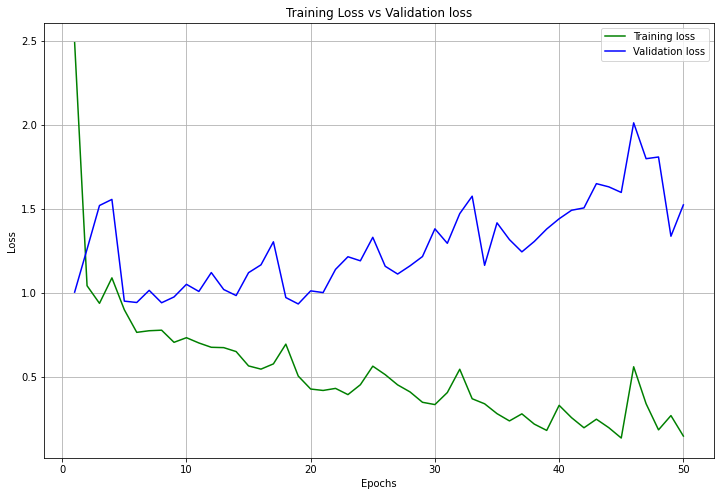

In [24]:
# Plot training loss vs validation loss
plotTrainLossVsValLoss(epochs_history=epochs_history_basic)

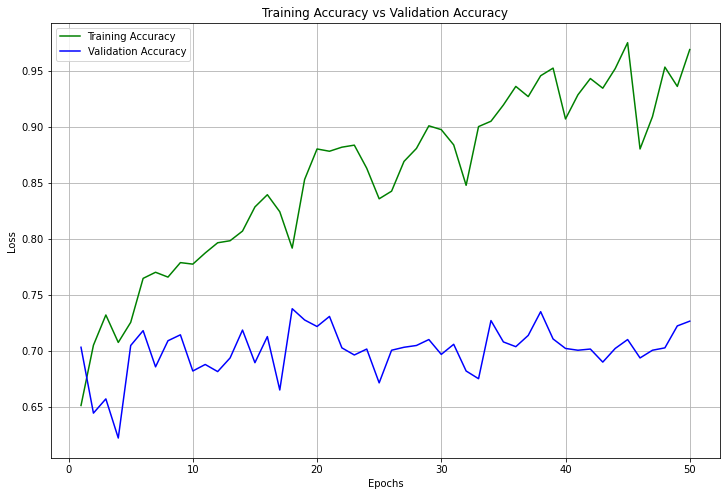

In [25]:
# Plot Training accuracy vs Validation accuracy
plotTrainAccuracyVsValAccuracy(epochs_history=epochs_history_basic)

## Training the Regularized Model

In [26]:
# we will now train the basicModel on training and validation data
# Now use the function to plot the confusion matrix

start = datetime.now()
epochs_history_regularized = regularizedModel.fit(features_train, target_train, epochs=EPOCHS,
                          validation_data=(features_val, target_val),
                          verbose=1)
end = datetime.now()
print(f"The training of basicModel completed in time - {end - start}")

Epoch 1/50
46/46 [==============================] - 2s 20ms/step - loss: 17.5601 - tp: 627.1064 - fp: 693.3830 - tn: 2101.0851 - fn: 770.1277 - accuracy: 0.6564 - precision: 0.4837 - recall: 0.4602 - auc: 0.6419 - val_loss: 1.0806 - val_tp: 17.0000 - val_fp: 11.0000 - val_tn: 1249.0000 - val_fn: 613.0000 - val_accuracy: 0.6698 - val_precision: 0.6071 - val_recall: 0.0270 - val_auc: 0.5625
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 1.0179 - tp: 110.5532 - fp: 49.6170 - tn: 1484.8511 - fn: 656.6809 - accuracy: 0.6910 - precision: 0.7459 - recall: 0.1216 - auc: 0.6154 - val_loss: 0.9793 - val_tp: 71.0000 - val_fp: 19.0000 - val_tn: 1241.0000 - val_fn: 559.0000 - val_accuracy: 0.6942 - val_precision: 0.7889 - val_recall: 0.1127 - val_auc: 0.7016
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.9632 - tp: 166.4681 - fp: 67.2553 - tn: 1467.2128 - fn: 600.7660 - accuracy: 0.7061 - precision: 0.7139 - recall: 0.1955 - auc: 0.6929 - val_loss

#### Check Performance Graphs - Regularized Model

<Figure size 864x576 with 0 Axes>

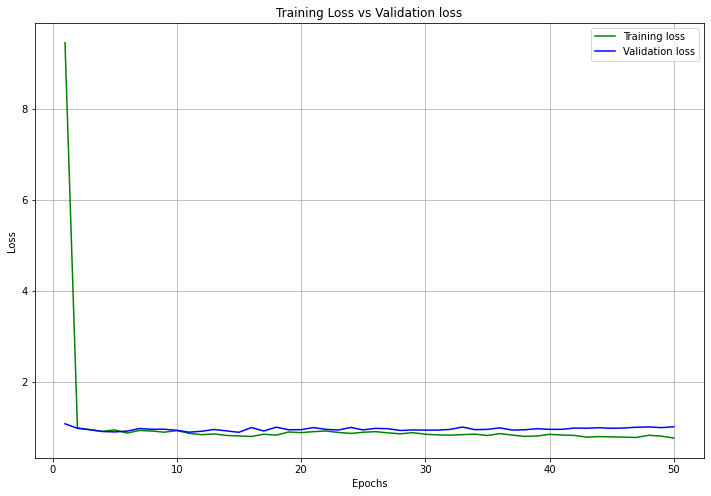

In [27]:
# Plot training loss vs validation loss
plotTrainLossVsValLoss(epochs_history=epochs_history_regularized)

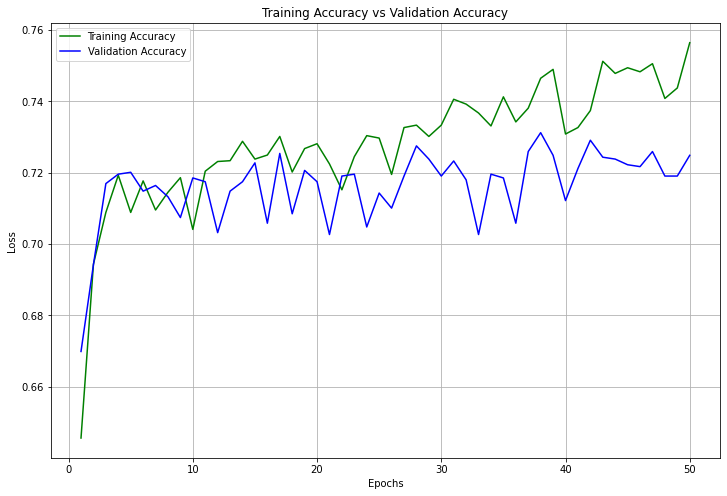

In [28]:
# Plot Training accuracy vs Validation accuracy
plotTrainAccuracyVsValAccuracy(epochs_history=epochs_history_regularized)

## Model Prediction

#### We will run the predictions and display the confusion matrix and classification report

### Predictions and Evaluation - Basic Model

In [29]:
# In order to use it in Confusion Matrix because its a multiclass prediction
basicModel_predictions = np.argmax(basicModel.predict(features_test), axis = 1)
target_test = np.argmax(target_test, axis=1)

In [30]:
print("Confusion Matrix")
print("\n")
print(confusion_matrix(target_test, basicModel_predictions))
print("\n")
print('Classification Report')
print("\n")
print(classification_report(target_test, basicModel_predictions))

Confusion Matrix


[[182  84  28]
 [136 124  45]
 [ 54  46 201]]


Classification Report


              precision    recall  f1-score   support

           0       0.49      0.62      0.55       294
           1       0.49      0.41      0.44       305
           2       0.73      0.67      0.70       301

    accuracy                           0.56       900
   macro avg       0.57      0.56      0.56       900
weighted avg       0.57      0.56      0.56       900



### Predictions and Evaluation - Regularized Model

In [31]:
# In order to use it in Confusion Matrix because its a multiclass prediction
regularizedModel_predictions = np.argmax(regularizedModel.predict(features_test), axis = 1)

In [32]:
print("Confusion Matrix")
print("\n")
print(confusion_matrix(target_test, regularizedModel_predictions))
print("\n")
print('Classification Report')
print("\n")
print(classification_report(target_test, regularizedModel_predictions))

Confusion Matrix


[[ 86 195  13]
 [ 56 228  21]
 [  9 121 171]]


Classification Report


              precision    recall  f1-score   support

           0       0.57      0.29      0.39       294
           1       0.42      0.75      0.54       305
           2       0.83      0.57      0.68       301

    accuracy                           0.54       900
   macro avg       0.61      0.54      0.53       900
weighted avg       0.61      0.54      0.53       900



## Conclusion

Following are some of the observations we are able to make from the modelling

#### Basic Model
1. In the basic Model, with just hidden layer, we see while the training accuracy continued an upward trend there was no significant changes in the validation accuracy. However this showed quite a significant amount of  variance.
2. The training loss although showed a decline, however the validation loss increased after approximately 20 epochs. Both the loss metrics showed significant variance
3. The overall accuracy was about 57% on which <strong> The most correct predictions was in class 2 (which is Pandas). This is obvious as Pandas as an animal has the most amount of difference than cats and dogs and hence the correspoding image array would be significantly different and hence easy to identify by the network. So Class Pandas, demonstrated 73% of accuracy </strong>

#### Regularized Model
1. In this model, dropout is used in the hidden layers at a rate of 20%.
2. The dropout regularization aligns the training loss and validation loss
3. The training accuracy and validation accuracy on a regularized model is also closer. So clearly dropout is reducing the overfitting
4. The overall accuracy on account of generalization increases by 4% on the test dataset, on which <strong> The most correct predictions was in class 2 (which is Pandas). This is obvious as Pandas as an animal has the most amount of difference than cats and dogs and hence the correspoding image array would be significantly different and hence easy to identify by the network. So Class Pandas, demonstrated 81% of accuracy </strong>
5. We see an increase in accuracy of the cats and dogs classes as well on account of the regularization on the test dataset. 

**The correct approach to model this image classification is to use a CNN and Bidirectional GRUs. The images are not standardized and moreover, apart of the core subject (cats, dogs and pandas), the images has other figures of a human, landscape, and even partial visibility of the subject. These are noise for the image classification, but classical ANN approach would try to learn from these noise as well. This results in lot of missclassification**
